In [1]:
!pip install -q transformers datasets accelerate scikit-learn matplotlib tqdm


In [2]:
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:",device)

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed(42)

Device: cuda


In [3]:
path = "/content/drive/MyDrive/IMDB Dataset.csv"
df = pd.read_csv(path)

def clean_text(text):
    text = re.sub(r"<[^>]+>", " ", str(text))            # Remove HTML tags
    text = text.lower()
    text = re.sub(r"(.)\1{2,}", r"\1\1", text)           # Reduce repeated chars
    text = re.sub(r"[^a-z0-9,.!?;:'\"()\-]", " ", text)  # Keep common punctuation
    text = re.sub(r"\s{2,}", " ", text).strip()
    return text

df["text"] = df["review"].apply(clean_text)
df["label"] = df["sentiment"].map({"negative":0, "positive":1})
df = df[["text","label"]]
print("Total samples:", len(df))
df.head()


Total samples: 50000


,text,label
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production. the filming tec...,1
2,i thought this was a wonderful way to spend ti...,1
3,basically there's a family where a little boy ...,0
4,"petter mattei's ""love in the time of money"" is...",1


In [4]:
print(df['label'].value_counts())


label
1    25000
0    25000
Name: count, dtype: int64


In [5]:
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")


Train: 40000, Val: 5000, Test: 5000


In [6]:
print(train_df['label'].value_counts())
print(val_df['label'].value_counts())
print(test_df['label'].value_counts())

label
1    20000
0    20000
Name: count, dtype: int64
label
0    2500
1    2500
Name: count, dtype: int64
label
0    2500
1    2500
Name: count, dtype: int64


In [7]:
MODEL_NAME = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
MAX_LEN = 256
BATCH_SIZE = 16

class IMDBDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        enc = self.tokenizer(text, truncation=True, padding='max_length',
                             max_length=self.max_len, return_tensors='pt')
        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.long)
        }

train_ds = IMDBDataset(train_df.text.tolist(), train_df.label.tolist(), tokenizer, MAX_LEN)
val_ds = IMDBDataset(val_df.text.tolist(), val_df.label.tolist(), tokenizer, MAX_LEN)
test_ds = IMDBDataset(test_df.text.tolist(), test_df.label.tolist(), tokenizer, MAX_LEN)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [8]:
from peft import LoraConfig, get_peft_model, TaskType

MODEL_NAME = "bert-base-uncased"
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=['query','value'],
    lora_dropout=0.05,
    bias='none',
    task_type=TaskType.SEQ_CLS
)
model = get_peft_model(model, lora_config)
model.to(device)

# Print trainable params
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())
print(f"Trainable params: {trainable_params} / {total_params}")


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainable params: 591362 / 110075140


In [12]:
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
epochs = 10
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=int(0.1*total_steps),
                                            num_training_steps=total_steps)


In [13]:
best_val_loss = float('inf')
patience = 3
counter = 0

In [14]:
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(1, epochs+1):
    print(f"\n======== LoRA Epoch {epoch}/{epochs} ========")

    # ---- Training ----
    model.train()
    total_train_loss, total_train_correct = 0, 0
    for batch in tqdm(train_loader, desc="Training"):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_train_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        total_train_correct += (preds == labels).sum().item()

    avg_train_loss = total_train_loss / len(train_loader)
    avg_train_acc = total_train_correct / len(train_ds)
    train_losses.append(avg_train_loss)
    train_accs.append(avg_train_acc)

    # ---- Validation ----
    model.eval()
    total_val_loss, total_val_correct = 0, 0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits
            total_val_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            total_val_correct += (preds == labels).sum().item()

    avg_val_loss = total_val_loss / len(val_loader)
    avg_val_acc = total_val_correct / len(val_ds)
    val_losses.append(avg_val_loss)
    val_accs.append(avg_val_acc)

    print(f"Epoch {epoch}: Train Loss={avg_train_loss:.4f}, Acc={avg_train_acc:.4f} | Val Loss={avg_val_loss:.4f}, Acc={avg_val_acc:.4f}")
    # ===== Early Stopping =====
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0
        torch.save(model.state_dict(), "best_model.pt")
    else:
        counter += 1
        print(f"No improvement in validation loss for {counter} epochs.")
        if counter >= patience:
            print("Early stopping triggered.")
            break



======== LoRA Epoch 1/10 ========


Training:   0%|          | 0/2500 [00:00<?, ?it/s]

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 1: Train Loss=0.3828, Acc=0.8071 | Val Loss=0.2373, Acc=0.9010

======== LoRA Epoch 2/10 ========


Training:   0%|          | 0/2500 [00:00<?, ?it/s]

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 2: Train Loss=0.2331, Acc=0.9071 | Val Loss=0.2135, Acc=0.9120

======== LoRA Epoch 3/10 ========


Training:   0%|          | 0/2500 [00:00<?, ?it/s]

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 3: Train Loss=0.2060, Acc=0.9192 | Val Loss=0.2043, Acc=0.9176

======== LoRA Epoch 4/10 ========


Training:   0%|          | 0/2500 [00:00<?, ?it/s]

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 4: Train Loss=0.1880, Acc=0.9264 | Val Loss=0.1992, Acc=0.9214

======== LoRA Epoch 5/10 ========


Training:   0%|          | 0/2500 [00:00<?, ?it/s]

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 5: Train Loss=0.1704, Acc=0.9342 | Val Loss=0.2080, Acc=0.9200
No improvement in validation loss for 1 epochs.

======== LoRA Epoch 6/10 ========


Training:   0%|          | 0/2500 [00:00<?, ?it/s]

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 6: Train Loss=0.1563, Acc=0.9406 | Val Loss=0.2048, Acc=0.9220
No improvement in validation loss for 2 epochs.

======== LoRA Epoch 7/10 ========


Training:   0%|          | 0/2500 [00:00<?, ?it/s]

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 7: Train Loss=0.1442, Acc=0.9458 | Val Loss=0.2064, Acc=0.9224
No improvement in validation loss for 3 epochs.
Early stopping triggered.


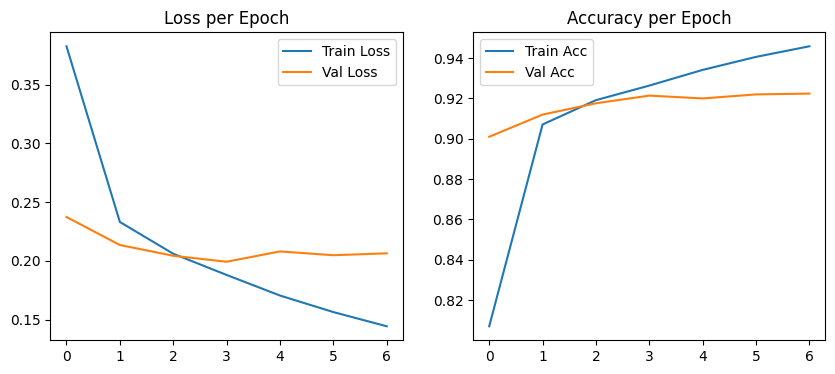

In [15]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title("Loss per Epoch")

plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.legend()
plt.title("Accuracy per Epoch")
plt.show()


In [16]:
model.load_state_dict(torch.load("best_model.pt"))
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

test_acc = 100. * np.sum(all_preds == all_labels) / len(all_labels)
print(f"\nTest Accuracy: {test_acc:.2f}%")




Testing:   0%|          | 0/313 [00:00<?, ?it/s]


Test Accuracy: 92.44%


In [19]:
from sklearn.metrics import ConfusionMatrixDisplay

              precision    recall  f1-score   support

           0     0.9138    0.9372    0.9254      2500
           1     0.9356    0.9116    0.9234      2500

    accuracy                         0.9244      5000
   macro avg     0.9247    0.9244    0.9244      5000
weighted avg     0.9247    0.9244    0.9244      5000



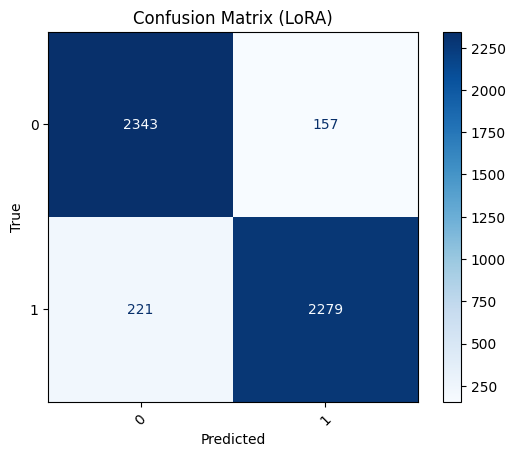

In [21]:
print(classification_report(all_labels, all_preds, digits=4))
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix (LoRA)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()